# Project UAV

Version 3.0

#### 1. call packages

In [1]:
import time

import frigidum
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, clear_output
from frigidum.examples import tsp
from matplotlib.patches import Ellipse
from scipy.spatial import distance_matrix
from sklearn.cluster import KMeans

#### 2. initial parameters

In [2]:
NUM_GU = 10  # number of ground users

X_MIN = 0  # minimum x-axis [meter]
X_MAX = 100  # maximum x-axis [meter]
Y_MIN = 0  # minimum y-axis [meter]
Y_MAX = 100  # maximum y-axis [meter]

UAV_ALTITUDE = 10  # altitude of uav [meter]
MAX_BEAM_ANGLE = 60  # maximum beam-forming angle [degree]
UAV_SPEED = 6  # uav speed [m/s]

# calculate maximum beam-forming diameter [meter]
MAX_BEAM_DIAMETER = 2 * UAV_ALTITUDE * np.tan(MAX_BEAM_ANGLE * np.pi / 180)

# calculate maximum distance between uav and gu [meter]
MAX_BEAM_DISTANCE = UAV_ALTITUDE / np.cos(MAX_BEAM_ANGLE * np.pi / 180)

X_GRID = 10  # number of x grid
Y_GRID = 10  # number of y grid

TX_POWER = 32  # transmit power [dBm]
F = 1e9  # frequency 1GH [Hz]
C = 299792458  # speed of light [m/s]

UAV_TX_POWER = 30  # uav's transmit power in [dBm]


#### 3. calculate receive power based on distance `d`

In [3]:
def calc_rx_power(d):
    # received power [mWh]
    return 1 * 10 ** ((TX_POWER - (20 * np.log10((4 * np.pi * d * F) / C))) / 10) * 1000

#### 4. generate location of gu

In [4]:
# generate location of gu randomly x,y,z [meters]
gu_x = np.random.uniform(low=X_MIN, high=X_MAX, size=(NUM_GU,))
gu_y = np.random.uniform(low=Y_MIN, high=Y_MAX, size=(NUM_GU,))
gu_z = np.zeros((NUM_GU,))


# given location of gu
gu_x = np.array([
    9.04330840e+01, 9.96817955e+01, 7.63398634e+01, 8.98037139e+01, 7.22245261e+01,
    8.36605843e+01, 10.27225613e-0, 4.05986793e+01, 5.80821532e+01, 9.93099118e+01
])

gu_y = np.array([
    13.73014649e+0, 78.77941627, 60.47122501, 71.19842815, 70.31373701,
    77.84923832, 60.52589075, 10.41285009, 85.11544206, 46.38436827
])

gu_z = np.array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


gu_xyz = np.array((gu_x, gu_y, gu_z)).T

#### 5. use `k-mean` algorithm

to find the center head of the gu, i use `k-mean` algorithm

In [5]:
# i use k-mean algorithm 
# to find the center with 7 cluster-head
kmeans = KMeans(
    n_clusters=7,
    n_init="auto"
).fit(gu_xyz)

centers = kmeans.cluster_centers_
clear_output()

#### 6. user `frigidum` algorithm

to find the route i use `frigidum` algorithm

In [6]:

# insert the center of the map as initial point
points = np.vstack(([[50, 50]], centers[:, 0:2]))

# i use frigidum package to find the optimal route
# can be used DAESOL's algorithm
tsp.nodes = points
tsp.nodes_count = len(points)
tsp.dist_eu = distance_matrix(points, points)

local_opt = frigidum.sa(
    random_start=tsp.random_start,
    objective_function=tsp.objective_function,
    neighbours=[
        tsp.euclidian_bomb_and_fix,
        tsp.euclidian_nuke_and_fix,
        tsp.route_bomb_and_fix,
        tsp.route_nuke_and_fix,
    ],
    copy_state=frigidum.annealing.naked,
    T_start=5,
    alpha=.8,
    T_stop=0.01,
    repeats=10 ** 2,
    post_annealing=tsp.local_search_2opt
)

clear_output()

In [7]:
# get the route variable 
tmp_route = local_opt[0]

# make the loop by adding the starting point 
# as the end point
route = np.append(
    np.roll(tmp_route, -np.squeeze(np.argwhere(tmp_route == 0))), 0
)


#### 7.  make uav flying only

Note: there is no hovering duration here

In [40]:
# calculate flying direction vectors
direction = {}
norm_direction = {}
for i in range(len(route) - 1):
    direction[i] = points[route[i + 1], :] - points[route[i], :]
    norm_direction[i] = direction[i] / np.linalg.norm(direction[i])


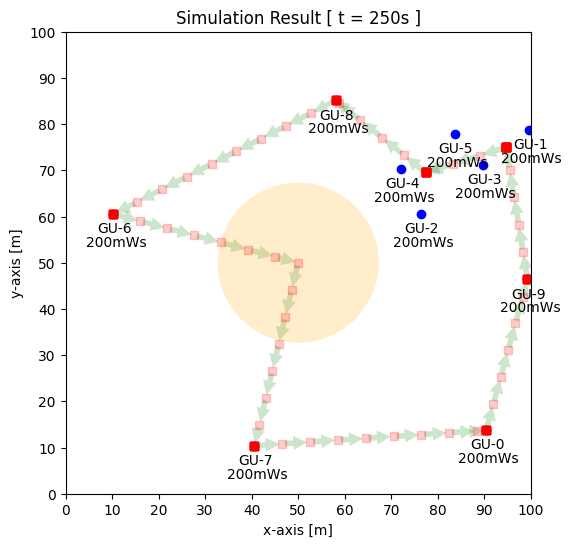

In [9]:
# call the figure
fig, ax = plt.subplots()
fig.set_figwidth(6)
fig.set_figheight(6)

# design the axis
ax.set_xlabel("x-axis [m]")
ax.set_ylabel("y-axis [m]")
ax.set_xticks(np.arange(X_MIN, X_MAX + 1, X_GRID))
ax.set_yticks(np.arange(Y_MIN, Y_MAX + 1, Y_GRID))
ax.set_xlim(X_MIN, X_MAX)
ax.set_ylim(Y_MIN, Y_MAX)
ax.grid(False)

# initial the batter of gus
gu_bat = np.zeros((NUM_GU,))

# plot initial location of gus with batteries
current_batt = []
for i in range(NUM_GU):
    ax.scatter(x=gu_x[i], y=gu_y[i], c="blue")
    ax.text(x=gu_x[i] - 3.5, y=gu_y[i] - 4, s=f"GU-{i}")
    current_batt.append(
        ax.text(x=gu_x[i] - 6, y=gu_y[i] - 7, s=f"{gu_bat[i]:.0f}mWs"))

# initial variables
t = 0  # time [second]

circle_points = np.vstack((points, [[50., 50.]]))

index = 0  # index of the route

GU_BAT_MAX = 200  # maximum battery capacity [mWs]

# initial uav location at time t = 0s
uav_time = {0: np.array([50., 50.])}
# uav_time[t] = np.squeeze(points[[route[0],], :])

# plot real time update trajectory
while True:
    # for t in range(150):
    t = t + 1  # increase time t

    # update the next location of uav
    uav_time[t] = np.squeeze(uav_time[t - 1] + UAV_SPEED * norm_direction[index])

    # calculate the next location vs. the end point
    tmp_vec = (uav_time[t] - circle_points[route[index + 1], :]) / (
        np.linalg.norm(uav_time[t] - circle_points[route[index + 1], :]))

    if index < len(circle_points) - 2:
        # calculate distance
        distance_uav2gu = distance_matrix(
            [np.append(uav_time[t - 1], UAV_ALTITUDE)], gu_xyz)

        # calculate receive power
        rx_power = calc_rx_power(distance_uav2gu)

        # get index
        tmp_a = (distance_uav2gu <= 0.8 * MAX_BEAM_DISTANCE)[0] > 0

        # update based index
        gu_bat[tmp_a] += (rx_power * (distance_uav2gu <= MAX_BEAM_DISTANCE))[0, tmp_a]
        # gu_bat[tmp_a] += rx_power[0, tmp_a]

        for i in range(len(gu_bat)):
            if gu_bat[i] > GU_BAT_MAX:
                gu_bat[i] = GU_BAT_MAX

        # if next location is longer than end point
        # thus, change direction

        if np.all(np.abs(tmp_vec - norm_direction[index]) < 1e-3):
            if np.min(gu_bat[tmp_a]) < GU_BAT_MAX:
                uav_time[t] = circle_points[route[index + 1], :]
            else:
                uav_time[t] = circle_points[route[index + 1], :]
                index = index + 1

    if index == len(circle_points) - 2:
        if np.all(np.abs(tmp_vec - norm_direction[index]) < 1e-3):
            uav_time[t] = circle_points[route[index + 1], :]
            index = index + 1

    # update title
    ax.set_title(f"Simulation Result [ t = {t}s ]")

    # plot arrow
    arrow = mpatches.FancyArrowPatch(
        (uav_time[t - 1][0], uav_time[t - 1][1]),
        (uav_time[t][0], uav_time[t][1]),
        edgecolor="none",
        facecolor="green",
        mutation_scale=20,
        zorder=0,
        alpha=0.2,
    )
    tmp = ax.add_patch(arrow)

    # scatter uav location
    scatter_uav = ax.scatter(
        x=uav_time[t][0],
        y=uav_time[t][1],
        c="red",
        marker="s",
        zorder=1,
        alpha=0.2,
    )

    # remove the previous beam circle and plot the new one
    if t > 1:
        beam_circle.remove()

    # update beam circle
    beam_circle = Ellipse(
        xy=(uav_time[t][0], uav_time[t][1]),
        width=MAX_BEAM_DIAMETER,
        height=MAX_BEAM_DIAMETER,
        angle=0,
        edgecolor="none",
        facecolor="orange",
        alpha=0.2,
        zorder=0,
    )
    uav_beam = ax.add_patch(beam_circle)

    # remove the previous battery text
    for i in range(NUM_GU):
        current_batt[i].remove()
        current_batt[i] = ax.text(
            x=gu_x[i] - 6,
            y=gu_y[i] - 7,
            s=f"{gu_bat[i]:.0f}mWs",
            zorder=10,
        )

    # update the figure
    display(fig)
    clear_output(wait=True)

    # set the time sleep
    time.sleep(0.0001)

    if index == len(circle_points) - 1:
        break
